In [6]:
import numpy as np
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [7]:
emotion_map = {
    0: 'angry',
    1: 'contempt',
    2: 'disgusted',
    3: 'fearful',
    4: 'happy',
    5: 'neutral',
    6: 'sad',
    7: 'surprised'
}
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'test')
for subset in [train_dir, val_dir]:
    for emotion in emotion_map.values():
        os.makedirs(os.path.join(subset, emotion), exist_ok=True)

In [8]:
print("Preparing image files...")
with open('affectnet_yolo_formatted_96x96.csv', 'r') as f:
    reader = csv.DictReader(f)
    for idx, row in enumerate(tqdm(reader)):
        pixels = np.fromstring(row['pixels'], sep=' ', dtype=np.uint8).reshape(96, 96)
        emotion = emotion_map[int(row['emotion'])]
        subset = 'train' if row['Usage'] == 'Training' else 'test'
        img_path = os.path.join(base_dir, subset, emotion, f'{idx}.png')
        Image.fromarray(pixels).save(img_path)

Preparing image files...


17465it [00:44, 388.60it/s]


In [9]:
batch_size = 64
num_epoch = 150

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

val_gen = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(96, 96),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

Found 12167 images belonging to 8 classes.
Found 5298 images belonging to 8 classes.


In [11]:
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,732,072 (37.12 MB)

 Trainable params: 9,730,152 (37.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_emotion_model_v4.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

print("Starting training...")
history_1 = model.fit(
    train_gen,
    epochs=num_epoch,
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save('emotion_model_v4.h5')

Starting training...


C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1688 - loss: 2.8939   

C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.16359, saving model to best_emotion_model_v4.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.1688 - loss: 2.8935 - val_accuracy: 0.1636 - val_loss: 3.1513 - learning_rate: 1.0000e-04
Epoch 2/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1994 - loss: 2.3533   
Epoch 2: val_accuracy improved from 0.16359 to 0.22411, saving model to best_emotion_model_v4.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.1994 - loss: 2.3532 - val_accuracy: 0.2241 - val_loss: 2.3477 - learning_rate: 1.0000e-04
Epoch 3/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2343 - loss: 2.1895   
Epoch 3: val_accuracy improved from 0.22411 to 0.29416, saving model to best_emotion_model_v4.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 843s 1s/step - accuracy: 0.2343 - loss: 2.1894 - val_accuracy: 0.2942 - val_loss: 1.9313 - learning_rate: 1.0000e-04
Epoch 4/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2651 - loss: 2.0777   


In [22]:
from tensorflow.keras.models import load_model

model = load_model('best_emotion_model_v5+++.keras')

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=4.0000e-06),
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_emotion_model_v6.keras',  
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

print("Continuing training for 50 more epochs...")
history_2 = model.fit(
    train_gen,
    epochs=num_epoch,  
    validation_data=val_gen,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    initial_epoch=100 
)

model.save('emotion_model_v5.keras')

Continuing training for 50 more epochs...
Epoch 101/150
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6691 - loss: 0.8916  
Epoch 101: val_accuracy improved from -inf to 0.69215, saving model to best_emotion_model_v6.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6691 - loss: 0.8915 - val_accuracy: 0.6921 - val_loss: 0.8153 - learning_rate: 4.0000e-06
Epoch 102/150
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6796 - loss: 0.8565  
Epoch 102: val_accuracy improved from 0.69215 to 0.69309, saving model to best_emotion_model_v6.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6796 - loss: 0.8565 - val_accuracy: 0.6931 - val_loss: 0.8142 - learning_rate: 4.0000e-06
Epoch 103/150
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6866 - loss: 0.8459  
Epoch 103: val_accuracy improved from 0.69309 to 0.69366, saving model to best_emotion_model_v6.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.6866 - loss: 0.8460 - val_accuracy: 0

In [13]:
from tensorflow.keras.models import load_model

model = load_model("emotion_model_v5.keras")
loss, accuracy = model.evaluate(val_gen)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

C:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.7062 - loss: 0.7854

Model Accuracy: 69.65%


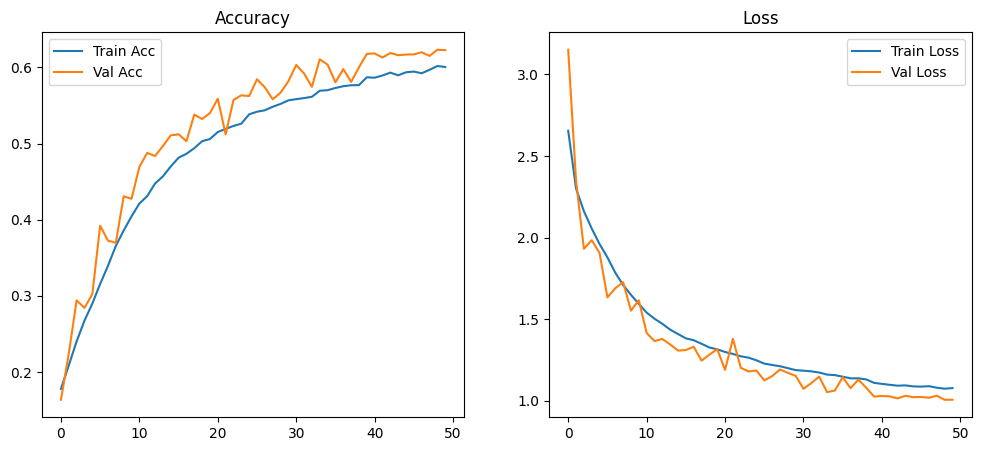

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='Train Acc')
plt.plot(history_1.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

6 unique face(s) detected.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


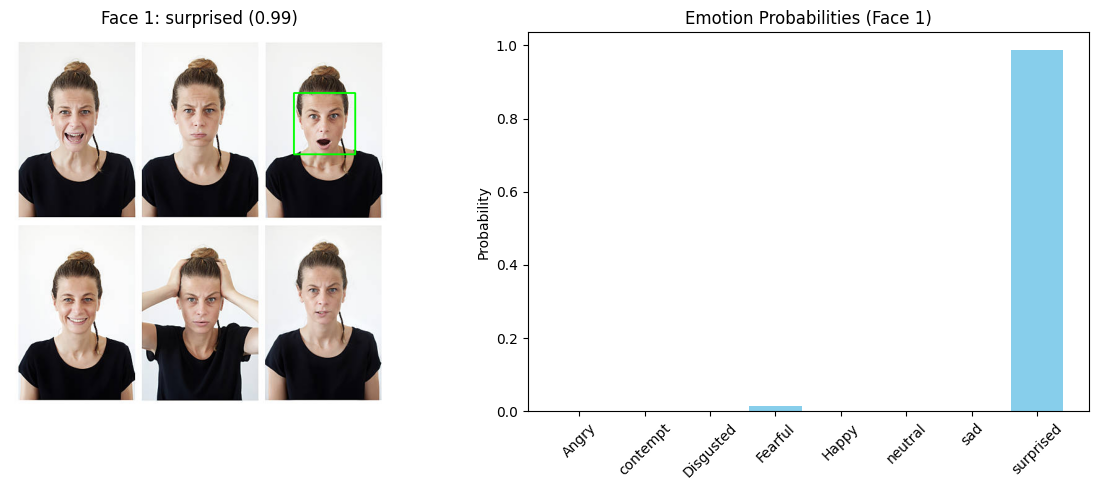

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


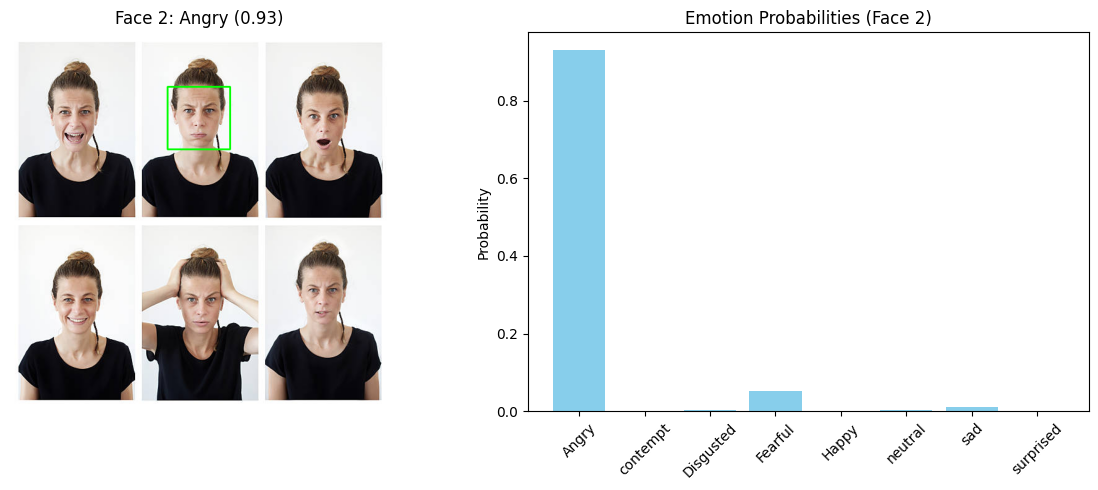

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


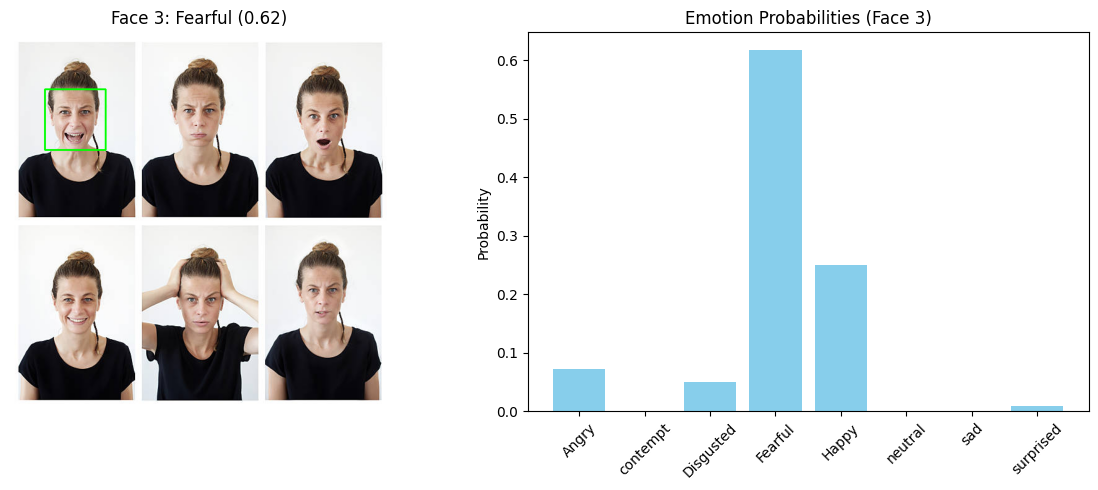

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


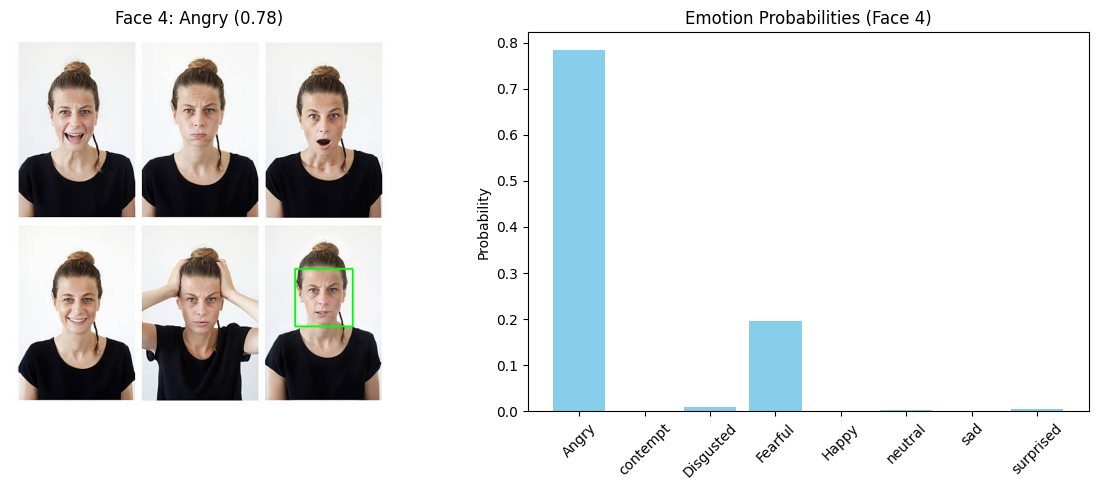

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


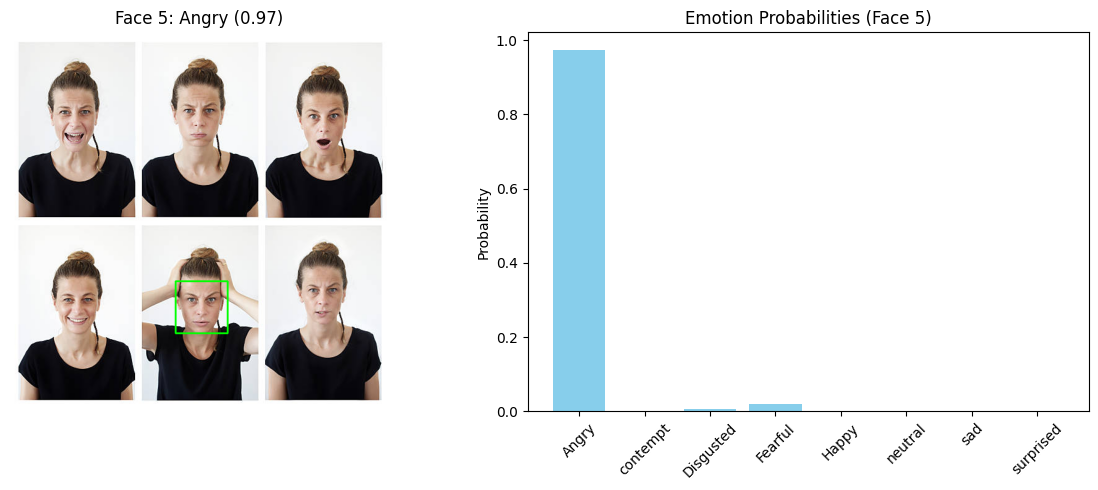

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


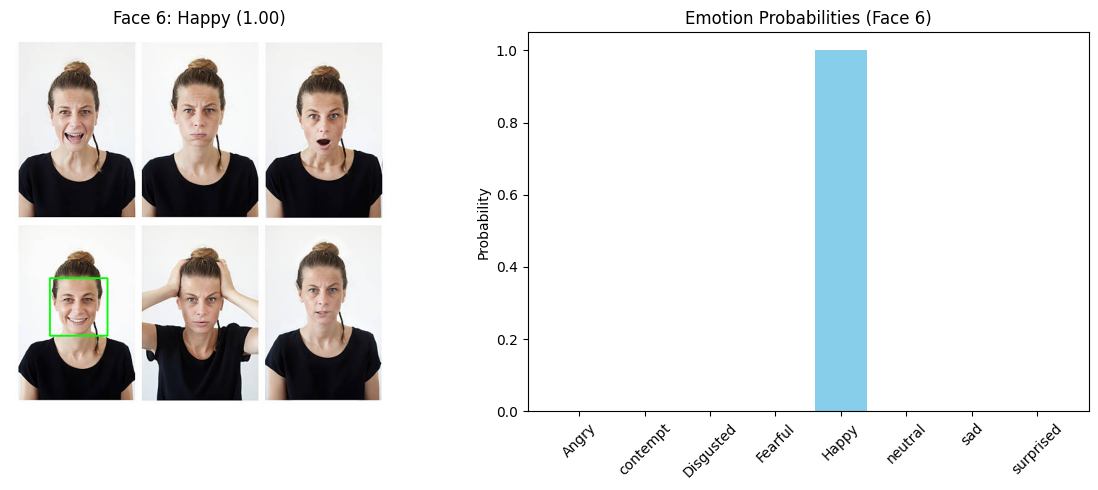

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model = load_model("emotion_model_v5.keras")
emotion_labels = ['Angry', 'contempt', 'Disgusted', 'Fearful', 'Happy', 'neutral', 'sad', 'surprised']

img_path = "istockphoto-490608166-612x612.jpg"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)

faces = list(faces)
faces, _ = cv2.groupRectangles(faces + faces, groupThreshold=1, eps=0.2)

print(f"{len(faces)} unique face(s) detected.")

for i, (x, y, w, h) in enumerate(faces):
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (96, 96))
    face_gray = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)
    face_normalized = face_gray / 255.0
    face_input = face_normalized.reshape(1, 96, 96, 1)

    prediction = model.predict(face_input)[0]
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    emotion = emotion_labels[predicted_class]

    img_copy = img.copy()
    cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.title(f"Face {i+1}: {emotion} ({confidence:.2f})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(emotion_labels, prediction, color='skyblue')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    plt.title(f'Emotion Probabilities (Face {i+1})')

    plt.tight_layout()
    plt.show()


In [ ]:

# Start webcam
cap = cv2.VideoCapture(0)

print("Starting webcam... Press 'q' to quit.")
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (96, 96))
        roi_gray = roi_gray / 255.0
        roi_gray = roi_gray.reshape(1, 96, 96, 1)

        prediction = model.predict(roi_gray, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        emotion = emotion_labels[predicted_class]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, f"{emotion} ({confidence:.2f})", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Show frame
    cv2.imshow('Real-time Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()


Starting webcam... Press 'q' to quit.
